This is just to demonstrate how the analysis will work for the POC, and also to show what the final exported notebook will look like. When that is implemented, get rid of this!

First, generate a fake dataset. In the future, let's check it in and use it if the [`--demo` flag](https://github.com/opendp/dp-creator-ii/issues/7) is given.

In [56]:
import csv
import random

def clip(n, lower, upper):
    return max(min(n, upper), lower)

csv_path = '/tmp/demo.csv'

with open(csv_path, 'w', newline='') as demo_handle:
    fields = ['student_id', 'class_year', 'hw_number', 'grade']
    writer = csv.DictWriter(demo_handle, fieldnames=fields)
    writer.writeheader()
    for student_id in range(1, 50):
        class_year = int(clip(random.gauss(2, 1), 1, 4))
        mean_grade = random.gauss(80, 5) + class_year * 2
        for hw_number in range(1, 10):
            grade = int(clip(random.gauss(mean_grade, 5), 0, 100))
            writer.writerow({
                'student_id': student_id,
                'class_year': class_year,
                'hw_number': hw_number,
                'grade': grade,
            })

Sanity check:

In [57]:
import polars

lf = polars.scan_csv(csv_path)
lf.collect()

student_id,class_year,hw_number,grade
i64,i64,i64,i64
1,3,1,81
1,3,2,88
1,3,3,84
1,3,4,80
1,3,5,84
…,…,…,…
49,2,5,83
49,2,6,85
49,2,7,84


Plot function from in https://github.com/opendp/dp-creator-ii/pull/35: remove redundant def here when that is merged.

In [58]:
import matplotlib.pyplot as plt
import numpy as np


def plot_error_bars_with_cutoff(
    y_values, x_min_label="min", x_max_label="max", y_cutoff=0, y_error=0
):
    x_values = 0.5 + np.arange(len(y_values))
    x_values_above = []
    x_values_below = []
    y_values_above = []
    y_values_below = []
    for x, y in zip(x_values, y_values):
        if y < y_cutoff:
            x_values_below.append(x)
            y_values_below.append(y)
        else:
            x_values_above.append(x)
            y_values_above.append(y)

    figure, axes = plt.subplots()
    color = "skyblue"
    shared = {
        "width": 0.8,
        "edgecolor": color,
        "linewidth": 1,
        "yerr": y_error,
    }
    axes.bar(x_values_above, y_values_above, color=color, **shared)
    axes.bar(x_values_below, y_values_below, color="white", **shared)
    axes.hlines([y_cutoff], 0, len(y_values), colors=["black"], linestyles=["dotted"])

    axes.set(xlim=(0, len(y_values)), ylim=(0, max(y_values)))
    axes.get_xaxis().set_ticks(
        ticks=[x_values[0], x_values[-1]],
        labels=[x_min_label, x_max_label],
    )
    axes.get_yaxis().set_ticks([])

In [59]:
class_years = lf.group_by('class_year').len().collect().sort('class_year')
class_years

class_year,len
i64,u32
1,207
2,135
3,99


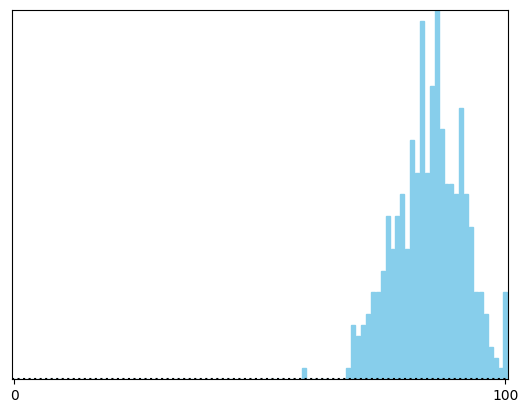

In [60]:
grades = lf.group_by('grade').len().collect().sort('grade')
df_0_100 = polars.from_dict({'grade': range(101)})
grades_0_100 = df_0_100.join(grades, on='grade', how='left').select(['len']).fill_null(0)
plot_error_bars_with_cutoff(grades_0_100.to_series().to_list(), '0', '100')